## pyprep

In [1]:
import mne
import pandas as pd
import scipy.io
import os
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from os.path import join as opj
from glob import glob
from pyprep.prep_pipeline import PrepPipeline
import time
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

from pyprep import NoisyChannels
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from autoreject import AutoReject
import seaborn as sns
def ensure_dir(ed):
    import os
    try:
        os.makedirs(ed)
    except OSError:
        if not os.path.isdir(ed):
            raise


## pyprep loop

sub-001
Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


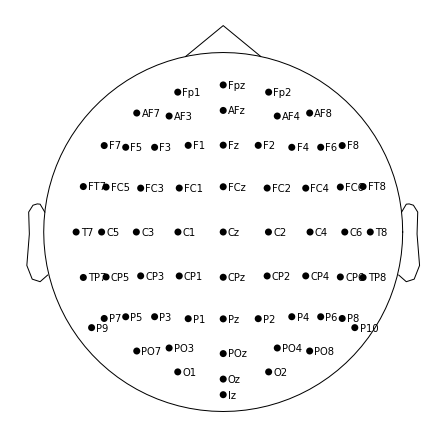

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Found 5 uniquely bad channels:

0 by NaN: []

1 by flat: ['POz']

0 by deviation: []

3 by HF noise: ['T7', 'Oz', 'P6']

2 by correlation: ['Oz', 'TP8']

1 by SNR: ['Oz']

0 by dropout: []

0 by RANSAC: []

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 40 components
Fitting ICA took 342.2s.
Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-dom

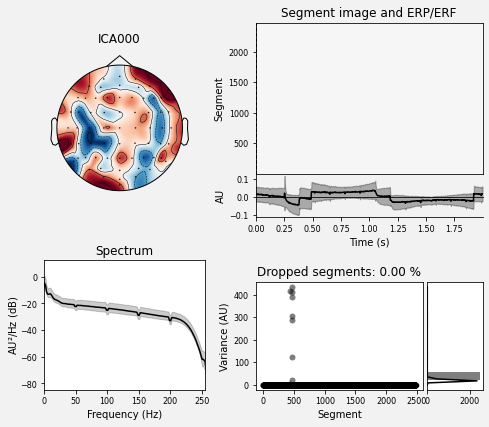

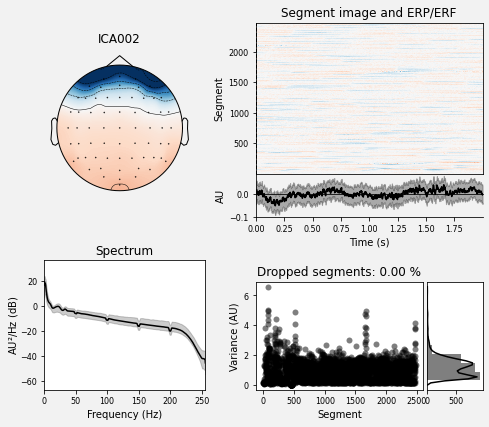

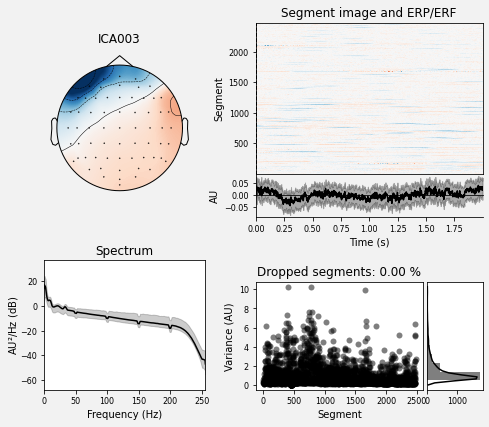

Creating RawArray with float64 data, n_channels=46, n_times=2541056
    Range : 0 ... 2541055 =      0.000 ...  4962.998 secs
Ready.
Using matplotlib as 2D backend.


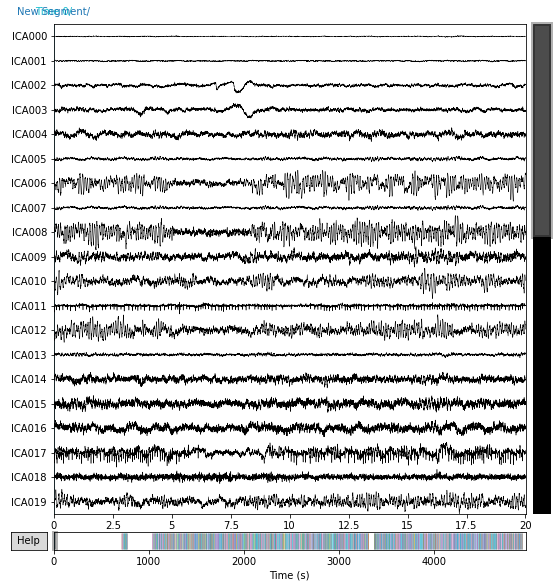

[0, 2, 3]
Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
---  ICA done ---


C:\Users\marti\AppData\Local\Temp\ipykernel_7896\1826897237.py:116: RuntimeWarning: This filename (c:\Users\marti\Desktop\code_mechanics\prepro_scripts\..\eeg_BIDS\Preprocessed_MNE\sub-001\sub-001_task_after_ica_raw_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_interp_ref.save(opj(prepro_dir,subject+'_task_after_ica_raw_filtered.fif'), overwrite = True)


In [2]:
# starting from a relative path /eeg_BIDS which you should also have
bids_root = '../eeg_BIDS/'

# get all subject IDs
subs=[ name for name in os.listdir(bids_root) if name.startswith('sub') ]

# This needs to be changed for ERP analyses!!! This is now for TFR
cutoff_l=1 # the low cutoff is 1Hz to get rid of the slow drifts
cutoff_h=None # we also get rid of anything higher than 100Hz which is typically not of relevance to human studies

# set the referencing method
reference = 'average'
for subject in subs:
    print(subject)
    bids_path = BIDSPath(subject = subject[-3:], 
                         task = 'xxxx', suffix = 'eeg',
                         datatype = 'eeg', root = bids_root)
    raw = mne.io.read_raw_brainvision(bids_path, 
                                      eog = ('VEOG', 'HEOG','IO1','IO2','Afp9','Afp10'), 
                                      misc = ('M1','M2'), 
                                      scale = 1.0, preload = True, verbose = False)

    montage = mne.channels.make_standard_montage("biosemi64")
    montage.plot()
    raw.set_montage(montage)

    sample_rate = raw.info["sfreq"]
    raw_copy = raw.copy()
    # start = time.time()

    # Filtering - apply the cutoffs defined outside the for loop
    raw_highpass = raw.copy().filter(l_freq = cutoff_l, h_freq = None)
    
    #specify the line noise frequencies
    freqs=np.arange(50, sample_rate/2, 50) # specify frequencies to remove
    
    # Power Line Noise Removal
    raw_notch = raw_highpass.copy().notch_filter(freqs=freqs) # apply a notch filter to remove frequencies

    # Find noisy channels
    nd = NoisyChannels(raw_notch)
    nd.find_all_bads(ransac=False) 
    bads = nd.get_bads(verbose=True)
    
    # add the bad channel info 
    raw_notch.info['bads']=bads    
    
    # Interpolating bad channels
    eeg_data_interp = raw_notch.copy()#.pick_types(eeg=True, exclude=[])
    eeg_data_interp.interpolate_bads(reset_bads=True)

    # referencing
    if reference=='average':
        eeg_data_interp_ref = eeg_data_interp.copy().set_eeg_reference(ref_channels='average')
    elif reference=='mastoid':
        eeg_data_interp_ref = eeg_data_interp.copy().set_eeg_reference(ref_channels=['EXG5','EXG6'])
    
    # output of this script is saved in bids_root/Preprocessed_MNE/subject
    prepro_dir = opj(bids_root,'Preprocessed_MNE',subject)
    ensure_dir(prepro_dir)
    
    #Detailed bad channels in each criteria before robust reference.
    with open(opj(prepro_dir,subject+'_bad_channels.txt'), 'w') as f:
        for item in bads:
            f.write("%s\n" % item)
    
    # save preprocessed data
    eeg_data_interp_ref.save(opj(prepro_dir,subject+'_task_after_pyprep_raw.fif'), overwrite = True)
    
    #-- ICA --- #
    ica = mne.preprocessing.ICA(n_components=40, random_state=1, allow_ref_meg=True)
    ica.fit(eeg_data_interp_ref)
    ica.exclude = []    

    # find which ICs match the EOG pattern
    # vertical
    eog_indices_veog, eog_scores_veog = ica.find_bads_eog(eeg_data_interp_ref, ch_name='VEOG')
    # horizontal
    eog_indices_hoeg, eog_scores_heog = ica.find_bads_eog(eeg_data_interp_ref, ch_name='HEOG')
    # get the union of the components detected from the two different channels
    union_indices_eog = list(set(eog_indices_veog).union(set(eog_indices_hoeg)))

    # barplot of ICA component "EOG match" scores
    fig1=ica.plot_properties(eeg_data_interp_ref, picks=union_indices_eog)
    for x in range(len(union_indices_eog)):
        fig1[x].savefig(opj(prepro_dir, subject +'-ICA_properties_'+str(x+1)+'.png'))

    # plot ICs applied to raw data, with EOG matches highlighted
    fig=ica.plot_sources(eeg_data_interp_ref)
    fig.savefig(opj(prepro_dir, subject +'-ICA_sources.png'))

    ica.exclude = union_indices_eog
    print(ica.exclude)

    # apply ICA to unfiltered data
    ica.apply(eeg_data_interp_ref)
    print("---  ICA done ---" )
    eeg_data_interp_ref.save(opj(prepro_dir,subject+'_task_after_ica_raw_filtered.fif'), overwrite = True)